In [ ]:
import pandas as pd
import numpy as np
import os

df = pd.read_csv('./data/train.csv')
sub = pd.read_csv('./data/sample_submission.csv')

# Make sure sorted by date
df = df.sort_values(by='date')
sub = sub.sort_values(by='date')

# Format date as date
df["date"] = pd.to_datetime(df["date"]).dt.date
sub["date"] = pd.to_datetime(sub["date"]).dt.date

In [ ]:
df.head()

In [ ]:
# This is going to be a common problem to fix, but tracking is doubled 9/27/2017 and 6/12/2018

def fix_double_tracking(df, col, date_col="date"):
    df.loc[(df[date_col] <= pd.to_datetime("2018-06-12").date()) & (df[date_col] >= pd.to_datetime("2017-09-27").date()), col] = \
    df.loc[(df[date_col] <= pd.to_datetime("2018-06-12").date()) & (df[date_col] >= pd.to_datetime("2017-09-27").date()), col] / 2
    return df


In [ ]:
# sleep_hours between 9/27/2017 and 6/12/2018 is doubled and needs to be divided by 2
df = fix_double_tracking(df, "sleep_hours")

In [ ]:
df.sleep_hours.hist()

In [ ]:
# Fill in missing dates (for time series)

start_date = df["date"].min()
print(f"Start date: {start_date}")

end_date = df["date"].max()
print(f"End date: {end_date}")

date_range = pd.date_range(start=start_date, end=end_date, freq="D")
date_range = pd.DataFrame({"date": date_range})
date_range["date"] = date_range["date"].dt.date

df = date_range.merge(df, on="date", how="left")
print('missing days: ', df.sleep_hours.isna().sum())

In [ ]:
# forward fill the missing values/targets
df["sleep_hours"] = df["sleep_hours"].fillna(method="ffill")

In [ ]:
#plot df_sleep.sleep_hours as dots by df_sleep.date
df.plot.scatter(x='date', y='sleep_hours')

In [ ]:
# Median of sleep_hours
med = df.sleep_hours.median()
print(f"Median sleep hours: {med}")


In [ ]:
sub_median = sub.copy()
sub_median["sleep_hours"] = med
sub_median.to_csv("./submissions/submission_median.csv", index=False)
sub_median.head()

# kaggle competitions submit -c kaggle-pog-series-s01e04 -f ./submissions/submission_median.csv -m "Trying just all median"
# Score : 0.67685

In [ ]:
# Median of sleep_hours
mean = df.sleep_hours.mean()
print(f"Median sleep hours: {mean}")

In [ ]:
sub_mean = sub.copy()
sub_mean["sleep_hours"] = mean
sub_mean.to_csv("./submissions/submission_mean.csv", index=False)
sub_mean.head()

# kaggle competitions submit -c kaggle-pog-series-s01e04 -f ./submissions/submission_mean.csv -m "Trying just all mean"
# Score: 0.67396

In [ ]:
import pytz
from datetime import datetime, timedelta
from pandas.tseries.holiday import USFederalHolidayCalendar
### Time series Data ###

df["day_of_week"] = pd.to_datetime(df["date"]).dt.dayofweek # Day of the week
df["month"] = pd.to_datetime(df["date"]).dt.month # Month
df["is_weekend"] = df["day_of_week"].apply(lambda x: 1 if x >= 5 else 0) # is_weekend

cal = USFederalHolidayCalendar()
holidays = cal.holidays(start="2014-01-01", end="2023-12-31") 
df["is_holiday"] = df["date"].apply(lambda x: 1 if x in holidays else 0) # is_holiday
df["is_workday"] = 1-(df["is_weekend"] + df["is_holiday"]) # is_workday

In [ ]:
df.head()

In [ ]:
# Create submissions by median by DOW
sub_median_group = sub.copy()
med = df.groupby("day_of_week")["sleep_hours"].median()
sub_median_group["day_of_week"] = pd.to_datetime(sub_median_group["date"]).dt.dayofweek
sub_median_group["sleep_hours"] = sub_median_group["day_of_week"].map(med)
sub_median_group = sub_median_group.drop("day_of_week", axis=1)
sub_median_group.to_csv("./submissions/submission_median_group.csv", index=False)
sub_median_group.head()

# kaggle competitions submit -c kaggle-pog-series-s01e04 -f ./submissions/submission_median_group.csv -m "Trying all median by DOW"
# Score: 0.67406

In [ ]:
# Create submissions by median by DOW
sub_mean_group = sub.copy()
mean = df.groupby("day_of_week")["sleep_hours"].mean()
sub_mean_group["day_of_week"] = pd.to_datetime(sub_mean_group["date"]).dt.dayofweek
sub_mean_group["sleep_hours"] = sub_mean_group["day_of_week"].map(mean)
sub_mean_group = sub_mean_group.drop("day_of_week", axis=1)
sub_mean_group.to_csv("./submissions/submission_mean_group.csv", index=False)
sub_mean_group.head()

# kaggle competitions submit -c kaggle-pog-series-s01e04 -f ./submissions/submission_mean_group.csv -m "Trying all mean by DOW"
# Score: ________________

In [ ]:
# Submission by median by DOW and and is_workday
sub_median_group_workday = sub.copy()
med = df.groupby(["day_of_week", "is_workday"])["sleep_hours"].median()
sub_median_group_workday["day_of_week"] = pd.to_datetime(sub_median_group_workday["date"]).dt.dayofweek
sub_median_group_workday["is_workday"] = 1-(sub_median_group_workday["day_of_week"].apply(lambda x: 1 if x >= 5 else 0) + sub_median_group_workday["date"].apply(lambda x: 1 if x in holidays else 0))
sub_median_group_workday["sleep_hours"] = sub_median_group_workday[["day_of_week", "is_workday"]].apply(lambda x: med[x[0]][x[1]], axis=1)
sub_median_group_workday = sub_median_group_workday.drop(["day_of_week", "is_workday"], axis=1)
sub_median_group_workday.to_csv("./submissions/submission_median_group_workday.csv", index=False)
sub_median_group_workday.head()
# kaggle competitions submit -c kaggle-pog-series-s01e04 -f ./submissions/submission_median_group_workday.csv -m "Trying all median by DOW and is_workday"
# Score: __________________

In [ ]:
# Submission by mean by DOW and and is_workday
sub_mean_group_workday = sub.copy()
mean = df.groupby(["day_of_week", "is_workday"])["sleep_hours"].mean()
sub_mean_group_workday["day_of_week"] = pd.to_datetime(sub_mean_group_workday["date"]).dt.dayofweek
sub_mean_group_workday["is_workday"] = 1-(sub_mean_group_workday["day_of_week"].apply(lambda x: 1 if x >= 5 else 0) + sub_mean_group_workday["date"].apply(lambda x: 1 if x in holidays else 0))
sub_mean_group_workday["sleep_hours"] = sub_mean_group_workday[["day_of_week", "is_workday"]].apply(lambda x: mean[x[0]][x[1]], axis=1)
sub_mean_group_workday = sub_mean_group_workday.drop(["day_of_week", "is_workday"], axis=1)
sub_mean_group_workday.to_csv("./submissions/submission_mean_group_workday.csv", index=False)
sub_mean_group_workday.head()
# kaggle competitions submit -c kaggle-pog-series-s01e04 -f ./submissions/submission_mean_group_workday.csv -m "Trying all mean by DOW and is_workday"
# Score: ________________

In [ ]:
from glob import glob

csv_files = glob("./data/xml_export/*.csv")

# Keep what files have ~80% of the dates in the training data
unique_dates = set(df["date"])

match_threshold = 0.75 # Threshold for matching

def intersection_ratio(set1, set2):
    return len(set1 & set2) / len(set1)

matching_csvs = []
for csv_file in csv_files:
    csv_df = pd.read_csv(csv_file)  
    try: 
        csv_df["date"] = pd.to_datetime(csv_df["startDate"]).dt.date
    except:
        csv_df["date"] = pd.to_datetime(csv_df["dateComponents"]).dt.date # Some use dateComponents instead of startDate

    unique_creation_dates = set(csv_df)

    ratio = intersection_ratio(unique_dates, unique_creation_dates)

    if ratio >= match_threshold:
        matching_csvs.append(csv_file)

print("CSV files with at least 75% of the 'dates' from the original DataFrame:")
for matching_csv in matching_csvs:
    print(matching_csv)

In [ ]:

csv_df.loc[csv_df["date"] >= pd.to_datetime("2021-01-01").date()]

In [ ]:
list = ["test1", "test2", "test3"]


In [ ]:
# Datasets worth exploring
basal_energy_burned = pd.read_csv('./data/xml_export/BasalEnergyBurned.csv', low_memory=False)
body_mass = pd.read_csv('./data/xml_export/BodyMass.csv', low_memory=False)
flights_climbed = pd.read_csv('./data/xml_export/FlightsClimbed.csv', low_memory=False)
step_count = pd.read_csv('./data/xml_export/StepCount.csv', low_memory=False)
body_mass_index = pd.read_csv('./data/xml_export/BodyMassIndex.csv', low_memory=False)
distance_walking_running = pd.read_csv('./data/xml_export/DistanceWalkingRunning.csv', low_memory=False)


In [ ]:

def parse_xml_output(path):
    # Import the csv
    csv_df = pd.read_csv(path, low_memory=False)
    base_name = os.path.basename(path).split(".")[0]
    
    # BodyMassIndex we want to avg not sum
    if base_name == "BodyMassIndex":
        agg_func = "mean"
    else:
        agg_func = "sum"
    
    # Convert startDate and endDate columns to datetime objects
    csv_df["startDate"] = pd.to_datetime(csv_df["startDate"]).dt.tz_convert ("US/Eastern")
    csv_df["endDate"] = pd.to_datetime(csv_df["endDate"]).dt.tz_convert ("US/Eastern")
    # Create date & time column
    csv_df["date"] = pd.to_datetime(csv_df["startDate"]).dt.date
    csv_df["time"] = pd.to_datetime(csv_df["startDate"]).dt.time
    
    # Group by date and perform aggregations
    csv_df = csv_df.groupby("date").agg(
        max_start_time=pd.NamedAgg(column="startDate", aggfunc="max"),
        min_start_time=pd.NamedAgg(column="startDate", aggfunc="min"),
        max_end_time=pd.NamedAgg(column="endDate", aggfunc="max"),
        min_end_time=pd.NamedAgg(column="endDate", aggfunc="min"),
        value_sum=pd.NamedAgg(column="value", aggfunc=agg_func)
    ).reset_index()
    
    # Check if the dates match between min_start_time and max_end_time
    csv_df["dates_match"] = csv_df.apply(
        lambda row: row["min_start_time"].date() == row["max_end_time"].date(), axis=1)
    csv_df = csv_df.rename(columns={"value_sum": base_name})
    
    # Assert if dates match in all rows
    # assert csv_df["dates_match"].all(), "Dates do not match in some rows"
    
    # Trigonomic Hours
    csv_df[base_name+"_mx_st_hr_sin"] = np.sin(2 * np.pi * csv_df["max_start_time"].dt.hour / 24)
    csv_df[base_name+"_mx_st_hr_cos"] = np.cos(2 * np.pi * csv_df["max_start_time"].dt.hour / 24)
    csv_df[base_name+"_mn_st_hr_sin"] = np.sin(2 * np.pi * csv_df["min_start_time"].dt.hour / 24)
    csv_df[base_name+"_mn_st_hr_cos"] = np.cos(2 * np.pi * csv_df["min_start_time"].dt.hour / 24)
    csv_df[base_name+"_mx_et_hr_sin"] = np.sin(2 * np.pi * csv_df["max_end_time"].dt.hour / 24)
    csv_df[base_name+"_mx_et_hr_cos"] = np.cos(2 * np.pi * csv_df["max_end_time"].dt.hour / 24)
    csv_df[base_name+"_mn_et_hr_sin"] = np.sin(2 * np.pi * csv_df["min_end_time"].dt.hour / 24)
    csv_df[base_name+"_mn_et_hr_cos"] = np.cos(2 * np.pi * csv_df["min_end_time"].dt.hour / 24) 
    
    #! HIGHLY ILLEGAL FEATURE??? (Step Count basically calculates sleep time)
    # Hours between startDate and next startDate (lag = -1)
    csv_df[base_name+"_hours_between"] = (csv_df["min_start_time"].shift(-1) - csv_df["max_start_time"]).dt.total_seconds() / 3600
    
    #Fix double tracking
    csv_df = fix_double_tracking(csv_df, base_name)
    
    # Drop unnecessary columns
    # csv_df = csv_df.drop(columns=["max_start_time", "min_start_time", "max_end_time", "min_end_time", "dates_match"])

    return csv_df

## Basal Energy Burned

In [ ]:
basal_energy_burned.head()

In [ ]:
# Value is the only useful feature
# Group by date and sum (set alias to basal_energy_burned)

# NOTE: Summing assumes duplicate tracking is not occuring between devices

basal_energy_burned = parse_xml_output("./data/xml_export/BasalEnergyBurned.csv")
basal_energy_burned.head()

In [ ]:
# Check distribution
basal_energy_burned.BasalEnergyBurned.hist()

In [ ]:
basal_energy_burned.plot.scatter(x='date', y='BasalEnergyBurned')

Looks like Rob got a better tracker or became more serious about racking in 2021

# Body Mass

In [ ]:
body_mass.head()

In [ ]:
body_mass["date"] = pd.to_datetime(body_mass["startDate"]).dt.date
body_mass = body_mass.groupby("date").sum().reset_index()
body_mass = body_mass.rename(columns={"value": "body_mass"})
body_mass = fix_double_tracking(body_mass, "body_mass")
body_mass.head()

In [ ]:
# Check distribution
body_mass.body_mass.hist()

In [ ]:
body_mass.plot.scatter(x='date', y='body_mass')

## Flights Climbed

In [ ]:
flights_climbed.head()

In [ ]:
flights_climbed["date"] = pd.to_datetime(flights_climbed["startDate"]).dt.date
flights_climbed = flights_climbed.groupby("date").sum().reset_index()
flights_climbed = flights_climbed.rename(columns={"value": "flights_climbed"})
flights_climbed = fix_double_tracking(flights_climbed, "flights_climbed")
flights_climbed.head()

In [ ]:
# Check distribution
flights_climbed.flights_climbed.hist()

# Definitely lognormal

In [ ]:
flights_climbed.plot.scatter(x='date', y='flights_climbed')

Very weird data. Will have to explore further. Possible duplication?

## Step Count

In [ ]:
step_count.head()

In [ ]:
step_count["date"] = pd.to_datetime(step_count["startDate"]).dt.date
step_count = step_count.groupby("date").sum().reset_index()
step_count = step_count.rename(columns={"value": "step_count"})
step_count = fix_double_tracking(step_count, "step_count")
step_count.head()

In [ ]:
# Check distribution
step_count.step_count.hist()

#kind of lognormal but not quite

In [ ]:
step_count.plot.scatter(x='date', y='step_count')

## Body Mass Index
This is a slow changing variable


In [ ]:
body_mass_index.head()

In [ ]:
body_mass_index["date"] = pd.to_datetime(body_mass_index["startDate"]).dt.date
body_mass_index = body_mass_index.groupby("date").mean(numeric_only =True).reset_index() #! MEAN here
body_mass_index = body_mass_index.rename(columns={"value": "body_mass_index"})
body_mass_index = body_mass_index.drop(columns=["sourceVersion", "device"], axis=1)
body_mass_index.head()

In [ ]:
# Check distribution
body_mass_index.body_mass_index.hist()

In [ ]:
body_mass_index.plot.scatter(x='date', y='body_mass_index')

Not measured frequently in 2012-2015

## Distance Walking/Running

In [ ]:
distance_walking_running.head()

In [ ]:
distance_walking_running = parse_xml_output("./data/xml_export/DistanceWalkingRunning.csv")
distance_walking_running.head()

In [ ]:
# Check distribution
distance_walking_running.DistanceWalkingRunning.hist()

# Lognormal

In [ ]:
distance_walking_running.plot.scatter(x='date', y='DistanceWalkingRunning')

In [ ]:
# Extract the hour and minute information from the datetime column and convert it to minutes
distance_walking_running['time_minutes'] = distance_walking_running['min_start_time'].dt.hour * 60 + distance_walking_running['min_start_time'].dt.minute

# Define the bin size (in minutes)
bin_size = 60  # 1-hour bins

# Create the bins using numpy
bins = np.arange(0, 24*60 + bin_size, bin_size)

# Plot the histogram using seaborn's histplot with time bins
plt.figure(figsize=(10, 6))
sns.histplot(data=distance_walking_running, x='time_minutes', bins=bins, kde=True)
plt.xticks(range(0, 24*60+1, bin_size), [f'{i:02d}:00' for i in range(0, 24+1, bin_size//60)], rotation=45)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Frequency of Time')
plt.show()

In [ ]:
distance_walking_running['time'].dt.seconds

# Feature Engineering

In [ ]:
# Combine all data into one DataFrame

for d in [basal_energy_burned, body_mass, flights_climbed, step_count, body_mass_index, distance_walking_running]:
    df = df.merge(d, on="date", how="left")

# Time series data so use ffill
df = df.fillna(method="ffill")
# Note: also ffills sleep_hours 

df.head()

In [ ]:
# Interactions
df["distance_per_step"] = df["distance"] / df["step_count"] # To account for jumping, hiking, etc.
df["calorie_per_step"] = df["basal_energy_burned"] / df["step_count"] # To account for intensity of exercise
d["calorie_per_distance"] = df["basal_energy_burned"] / df["distance"] # Gym days vs. Outdoor days

df.head()

In [ ]:
# Time series predictions to come later
# Try a column for every sleep_hours for the past week


# YData Profiling


In [1]:
from helper import POG4_Dataset

data = POG4_Dataset()

#print(df.columns.to_list())

2023-03-23 01:20:38,115 - INFO - Creating XML data
2023-03-23 01:20:43,160 - INFO - missing days: 154
2023-03-23 01:20:43,162 - INFO - Featurizing time series data
2023-03-23 01:20:43,193 - INFO - Creating interactions...
2023-03-23 01:20:43,206 - INFO - dropped non-unique columns: ['BasalEnergyBurned_startDate_min_hr_sin', 'BasalEnergyBurned_startDate_min_hr_cos', 'StepCount_startDate_min_hr_sin', 'StepCount_startDate_min_hr_cos', 'BodyMassIndex_startDate_max_hr_sin', 'BodyMassIndex_startDate_max_hr_cos', 'BodyMassIndex_startDate_min_hr_sin', 'BodyMassIndex_startDate_min_hr_cos', 'BodyMassIndex_endDate_max_hr_sin', 'BodyMassIndex_endDate_max_hr_cos', 'BodyMassIndex_endDate_min_hr_sin', 'BodyMassIndex_endDate_min_hr_cos', 'BodyMassIndex_hrs_btween', 'DistanceWalkingRunning_startDate_min_hr_sin', 'DistanceWalkingRunning_startDate_min_hr_cos', 'is_holiday']
2023-03-23 01:20:43,210 - INFO - dropped null columns: []
2023-03-23 01:20:43,213 - INFO - Featurizing time series data
2023-03-23 0

In [2]:
data.features

Index(['date', 'sleep_hours', 'BasalEnergyBurned',
       'BasalEnergyBurned_startDate_max_hr_sin',
       'BasalEnergyBurned_startDate_max_hr_cos',
       'BasalEnergyBurned_endDate_max_hr_sin',
       'BasalEnergyBurned_endDate_max_hr_cos',
       'BasalEnergyBurned_endDate_min_hr_sin',
       'BasalEnergyBurned_endDate_min_hr_cos', 'BasalEnergyBurned_hrs_btween',
       'BodyMass', 'BodyMass_startDate_max_hr_sin',
       'BodyMass_startDate_max_hr_cos', 'BodyMass_startDate_min_hr_sin',
       'BodyMass_startDate_min_hr_cos', 'BodyMass_endDate_max_hr_sin',
       'BodyMass_endDate_max_hr_cos', 'BodyMass_endDate_min_hr_sin',
       'BodyMass_endDate_min_hr_cos', 'BodyMass_hrs_btween', 'FlightsClimbed',
       'FlightsClimbed_startDate_max_hr_sin',
       'FlightsClimbed_startDate_max_hr_cos',
       'FlightsClimbed_startDate_min_hr_sin',
       'FlightsClimbed_startDate_min_hr_cos',
       'FlightsClimbed_endDate_max_hr_sin',
       'FlightsClimbed_endDate_max_hr_cos',
       'Flights

In [ ]:

df["sleep_h"].value_counts(normalize=True, dropna=False).iloc[0] > threshold]


In [3]:
from ydata_profiling import ProfileReport

profile_main = ProfileReport(df, title="POG4 Profiling Report", explorative=True)
profile_main.to_file("data_profile_main.html")

profile_ts = ProfileReport(df, tsmode=True, sortby="date", title="Time-Series EDA", explorative=True)
profile_ts.to_file("data_profile_ts.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/home/sebastian/mambaforge/envs/pog4-sleep/lib/python3.9/site-packages/ydata_profiling/model/pandas/describe_timeseries_pandas.py:117: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  mad = pos_fft_above_med["ampl"].mad()
/home/sebastian/mambaforge/envs/pog4-sleep/lib/python3.9/site-packages/ydata_profiling/model/pandas/describe_timeseries_pandas.py:117: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  mad = pos_fft_above_med["ampl"].mad()
/home/sebastian/mambaforge/envs/pog4-sleep/lib/python3.9/site-packages/ydata_profiling/model/pandas/describe_timeseries_pandas.py:117: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  mad = pos_fft_above_med["ampl"].mad(

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
# Merge Submissions test

from glob import glob

files = glob("./submissions/*.csv")

sub_all = pd.concat([pd.read_csv(f) for f in files], axis=0, ignore_index=True)
sub_all = sub_all.groupby("date")["sleep_hours"].mean().reset_index()
sub_all.to_csv("./submissions/submission_combined.csv", index=False)
sub_all.head()


,date,sleep_hours
0,2022-01-01,6.785190
1,2022-01-02,6.697302
2,2022-01-03,6.634091
3,2022-01-04,6.548654
4,2022-01-05,6.512289


In [1]:
from data import POG4_Dataset

data = POG4_Dataset()
data.create_lags()


INFO - Creating XML data
INFO - Creating activity data
INFO - Missing days: 35
INFO - Featurizing time series data
INFO - Creating interactions...
INFO - Dropped null columns: ['RunningSpeed', 'RunningSpeed_hrs_btween', 'AppleWalkingSteadiness', 'AppleWalkingSteadiness_hrs_btween', 'LowHeartRateEvent', 'LowHeartRateEvent_hrs_btween', 'RunningGroundContactTime', 'RunningGroundContactTime_hrs_btween', 'DistanceCycling', 'DistanceCycling_hrs_btween', 'HandwashingEvent', 'HandwashingEvent_hrs_btween', 'NumberOfTimesFallen', 'NumberOfTimesFallen_hrs_btween', 'MindfulSession', 'MindfulSession_hrs_btween', 'SixMinuteWalkTestDistance', 'SixMinuteWalkTestDistance_hrs_btween', 'HKDataTypeSleepDurationGoal', 'HKDataTypeSleepDurationGoal_hrs_btween', 'Height', 'Height_hrs_btween', 'RunningStrideLength', 'RunningStrideLength_hrs_btween', 'HeartRateRecoveryOneMinute', 'HeartRateRecoveryOneMinute_hrs_btween', 'SwimmingStrokeCount', 'SwimmingStrokeCount_hrs_btween', 'DietaryEnergyConsumed', 'DietaryEn

In [2]:
print('nas', data.X.HeartRate_sleep_hours.isna().sum())
print(len(data.X))
data.X.HeartRate_sleep_hours.value_counts()

AttributeError: 'DataFrame' object has no attribute 'HeartRate_sleep_hours'

<Axes: >

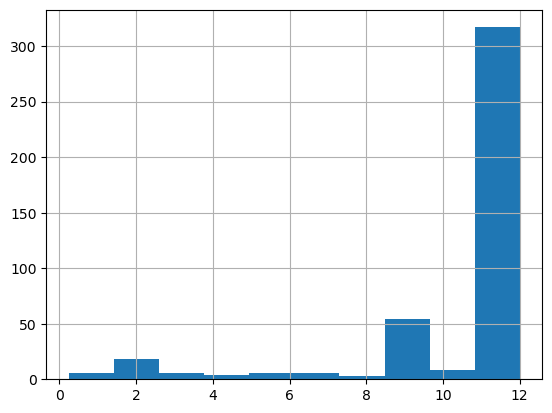

In [3]:
data.X.HeartRate_sleep_hours.hist()

In [10]:
import pandas as pd
print(pd.value_counts(data.X.dtypes))


float64    252
int64        6
dtype: int64


In [10]:
import pandas as pd
pd.concat([data.X_test.reset_index(drop=True), data.y_test.reset_index(drop=True)], axis=1).isna().sum().sum()

0

In [12]:
1915/2508

0.7635566188197768

In [17]:
import wandb
import pandas as pd

api = wandb.Api()
runs = api.runs("sgobat/pog4_xgb")

# Initialize a list to store feature importances from all runs
feature_importances_list = []

# Iterate through the runs and fetch feature importances
for run in runs:
    # Fetch logged feature importances from the current run
    feature_importances = {
        key.replace("feature/", ""): value
        for key, value in run.summary.items()
        if key.startswith("feature/")
    }
    
    # Append the fetched feature importances to the list
    feature_importances_list.append(feature_importances)

# Create a DataFrame from the list of feature importances
df = pd.DataFrame(feature_importances_list)

# Calculate the mean feature importances across all runs
mean_feature_importances = df.mean().sort_values(ascending=False)

with pd.option_context("display.max_rows", 100):
    display(mean_feature_importances)

AppleStandTime_hrs_btween                    0.062923
BodyMassIndex_hrs_btween                     0.026904
OxygenSaturation_hrs_btween                  0.024848
AppleExerciseTime_hrs_btween                 0.019546
is_weekend                                   0.017552
AppleStandHour_hrs_btween                    0.017337
appleStandHours                              0.017083
VO2Max_hrs_btween                            0.016167
day_of_week                                  0.015953
max_startDate_min_hr                         0.014294
AppleStandTime                               0.014260
FlightsClimbed_hrs_btween                    0.014250
month_sin                                    0.014126
VO2Max                                       0.014061
dow_median                                   0.013778
appleExerciseTime                            0.013189
max_startDate_max_hr                         0.013155
avg_startDate_min_sin                        0.013125
day_of_year                 

In [18]:
mean_feature_importances.mean()

0.010752688257160702

In [19]:
for i in mean_feature_importances.index:
    print(i)

AppleStandTime_hrs_btween
BodyMassIndex_hrs_btween
OxygenSaturation_hrs_btween
AppleExerciseTime_hrs_btween
is_weekend
AppleStandHour_hrs_btween
appleStandHours
VO2Max_hrs_btween
day_of_week
max_startDate_min_hr
AppleStandTime
FlightsClimbed_hrs_btween
month_sin
VO2Max
dow_median
appleExerciseTime
max_startDate_max_hr
avg_startDate_min_sin
day_of_year
calorie_per_step
min_startDate_min_hr
avg_endDate_min_hr
avg_startDate_min_hr
DistanceWalkingRunning_hrs_btween
AppleExerciseTime
HeartRateVariabilitySDNN_hrs_btween
min_endDate_min_hr
calorie_per_distance
avg_endDate_min_sin
HeadphoneAudioExposure
distance_per_step
doy_cos
avg_endDate_max_sin
avg_startDate_max_sin
DistanceWalkingRunning
month_cos
StepCount
StepCount_hrs_btween
HeadphoneAudioExposure_hrs_btween
BasalEnergyBurned_hrs_btween
avg_endDate_max_cos
avg_startDate_min_cos
month
max_endDate_min_hr
min_startDate_max_hr
min_endDate_max_hr
activeEnergyBurned
avg_endDate_max_hr
BodyMassIndex
doy_sin
avg_startDate_max_cos
avg_endDate_m

In [ ]:
["AppleStandTime_hrs_btween",
"BodyMassIndex_hrs_btween",
"OxygenSaturation_hrs_btween",
"AppleExerciseTime_hrs_btween",
"is_weekend",
"AppleStandHour_hrs_btween",
"appleStandHours",
"VO2Max_hrs_btween",
"day_of_week",
"max_startDate_min_hr",
"AppleStandTime",
"FlightsClimbed_hrs_btween",
"month_sin",
"VO2Max",
"dow_median",
"appleExerciseTime",
"max_startDate_max_hr",
"avg_startDate_min_sin",
"day_of_year",
"calorie_per_step",
"min_startDate_min_hr",
"avg_endDate_min_hr",
"avg_startDate_min_hr",
"DistanceWalkingRunning_hrs_btween",
"AppleExerciseTime",
"HeartRateVariabilitySDNN_hrs_btween",
"min_endDate_min_hr",
"calorie_per_distance",
"avg_endDate_min_sin",
"HeadphoneAudioExposure",
"distance_per_step",
"doy_cos",
"avg_endDate_max_sin",
"avg_startDate_max_sin",
"DistanceWalkingRunning",
"month_cos",
"StepCount",
"StepCount_hrs_btween",
"HeadphoneAudioExposure_hrs_btween",
"BasalEnergyBurned_hrs_btween",
"avg_endDate_max_cos",
"avg_startDate_min_cos",
"month"]